# Building the Cornerstone of a Chatbot: Creating a Clustering-Based Intent Identification Engine

Project developed for a Hackathon Event on the Bootcamp: Data Science and Business Intelligence offered by WE LEAD in collaboration with Code.Hub.

The task was given to us by people working at Netcompany, this code is an improved and better organised version of the code I created the day of the Hackathon.

We were asked to develop a **clustering algorithm** for **identifying intent categories** based on a dataset by a real telecommunications company.

**Contents**
1) Preprocessing
2) Feature Extraction
3) Metrics and clustering 
4) Evaluation


# 1. Preprocessing

In [ ]:
import pandas as pd
import re
import random
import umap
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy.stats import zscore
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter
import os

/opt/homebrew/Caskroom/miniconda/base/envs/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ioannakaragianni/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ioannakaragianni/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
# seed for reproducibility
import numpy as np
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

In [4]:
# stopwords for english and greek
english_stopwords = set(stopwords.words('english'))
greek_stopwords = set(stopwords.words('greek'))
# models for lemmatization
nlp_greek = spacy.load("el_core_news_sm")  # greek
nlp_english = spacy.load("en_core_web_sm")  # english

In [5]:
# dataset
nb_path = os.path.abspath('')
file_path = "files/Customer_Utterances.csv"
df = pd.read_csv(file_path)
data = df["Utterance"].astype(str).tolist()

In [6]:
# tokenizing the sentences to get the word counts
token_counts = [len(word_tokenize(utterance)) for utterance in data]
print("Token counts for each sentence:", token_counts)

Token counts for each sentence: [8, 9, 5, 2, 5, 4, 8, 8, 6, 3, 1, 4, 3, 6, 5, 2, 9, 2, 5, 5, 2, 9, 4, 2, 5, 9, 3, 5, 6, 8, 9, 7, 4, 6, 5, 7, 5, 6, 4, 5, 6, 8, 5, 6, 7, 2, 8, 4, 7, 5, 8, 3, 4, 2, 4, 7, 6, 14, 5, 5, 6, 3, 2, 6, 7, 5, 7, 5, 4, 7, 8, 8, 10, 5, 9, 1, 10, 4, 4, 7, 1, 8, 1, 5, 5, 7, 9, 7, 7, 2, 2, 6, 9, 3, 11, 12, 8, 2, 1, 7, 9, 9, 6, 12, 5, 7, 4, 9, 4, 8, 4, 9, 12, 3, 6, 8, 8, 7, 3, 6, 7, 3, 3, 3, 7, 9, 8, 8, 7, 6, 3, 7, 5, 5, 6, 7, 5, 5, 2, 4, 3, 5, 4, 8, 3, 6, 1, 8, 5, 7, 6, 5, 8, 3, 5, 6, 6, 3, 2, 3, 12, 10, 4, 2, 4, 6, 5, 14, 6, 8, 5, 9, 2, 2, 8, 7, 6, 5, 5, 5, 11, 9, 6, 7, 7, 6, 3, 6, 8, 4, 7, 5, 6, 9, 6, 2, 9, 7, 5, 6, 5, 5, 3, 5, 9, 2, 5, 7, 6, 10, 6, 6, 6, 5, 6, 9, 6, 8, 7, 10, 7, 7, 5, 5, 6, 5, 3, 3, 9, 5, 3, 8, 3, 5, 5, 5, 3, 3, 4, 5, 10, 11, 5, 5, 8, 3, 14, 3, 7, 5, 13, 2, 1, 8, 13, 5, 4, 3, 8, 3, 8, 5, 6, 7, 7, 4, 4, 6, 3, 5, 8, 7, 3, 6, 10, 6, 6, 6, 5, 13, 6, 5, 9, 10, 4, 4, 13, 6, 6, 9, 4, 2, 1, 6, 11, 4, 8, 4, 6, 6, 2, 5, 5, 7, 2, 2, 5, 7, 8, 5, 7, 7, 5, 4, 8,

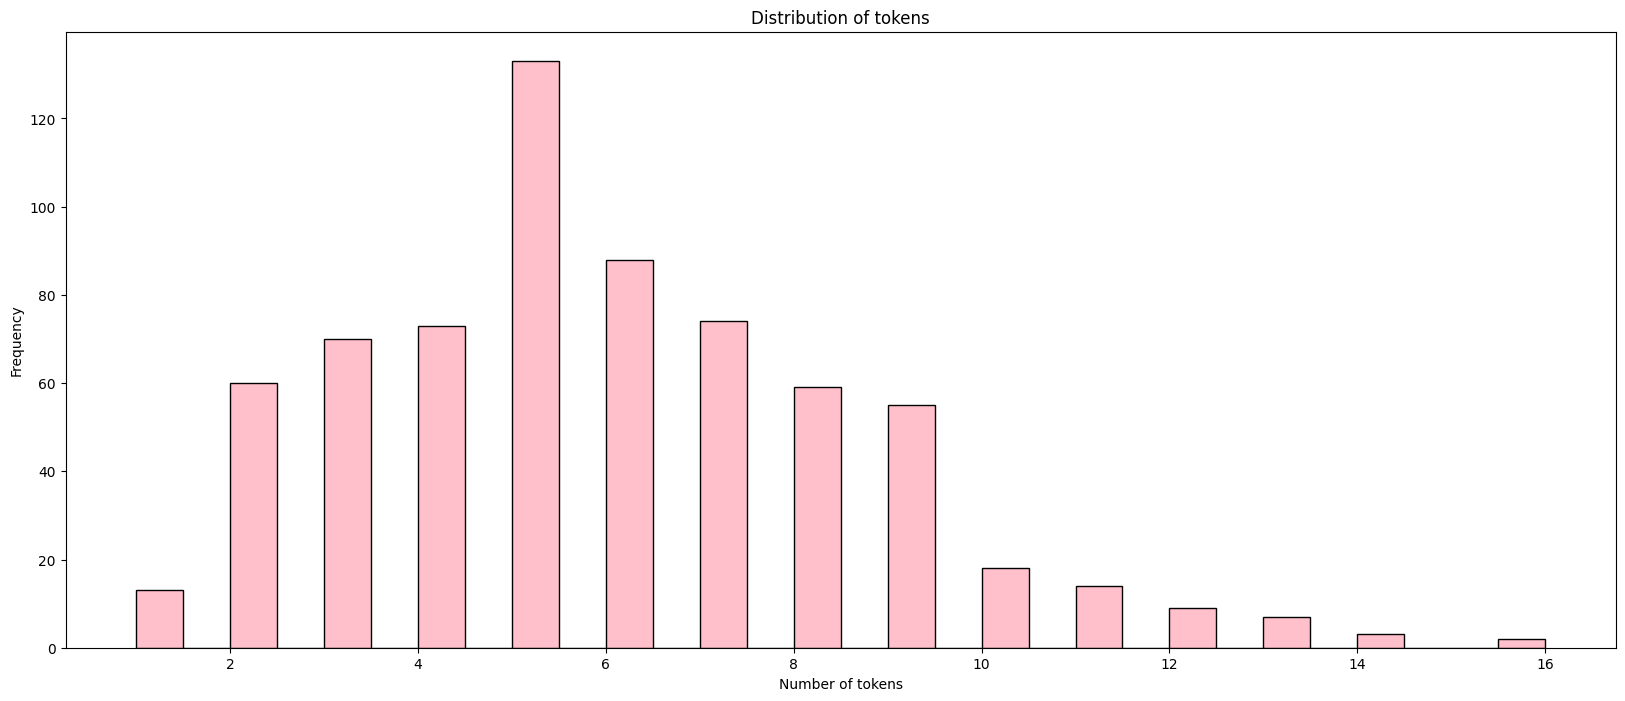

In [7]:
# plotting histogram of token counts
plt.figure(figsize=(20, 8))
plt.hist(token_counts, bins=30, edgecolor='black', color='pink')
plt.title("Distribution of tokens")
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")
plt.show()

# Using z-score to find the outliers (sentences with more tokens than expected)


![Screenshot 2025-02-06 at 21.59.25.png](<attachment:Screenshot 2025-02-06 at 21.59.25.png>)
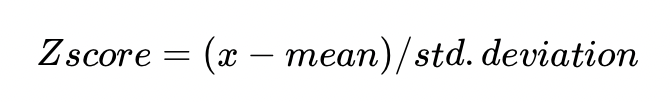

In [8]:
# setting the threshold to 3 
z_scores = zscore(token_counts)
outlier_threshold = 3
outliers = [i for i, score in enumerate(z_scores) if abs(score) > outlier_threshold]
# printing outlier idxs and total instances of outleirs
print(f"Outliers identified (Z-score > {outlier_threshold}):", outliers)
print(f"Number of outliers: {len(outliers)}")

Outliers identified (Z-score > 3): [57, 167, 246, 411, 414]
Number of outliers: 5


In [9]:
df_cleaned = df.loc[~df.index.isin(outliers)].reset_index(drop=True)
data = df_cleaned["Utterance"].astype(str).tolist()

In [10]:
# text preprocessing function
def preprocess_text(text):
    text = text.lower()
    try:
        lang = detect(text)  # detect language (Greek or English)
    except:
        lang = "el"  # default to Greek if language detection fails

    # regex removal of special chars in both languages
    text = re.sub(r'[^a-zA-Zα-ωΑ-ΩάέήίόύώΆΈΉΊΌΎΏ\s]', '', text)

    # choose the stopwords & lemmatization based on detected language
    if lang == "el":  # greek
        words = text.split()
        words = [word for word in words if word not in greek_stopwords]  #stopwords
        doc = nlp_greek(" ".join(words))
        words = [token.lemma_ for token in doc]  #lemmatization
    else:  # english
        words = text.split()
        words = [word for word in words if word not in english_stopwords]  # stopwords
        doc = nlp_english(" ".join(words))
        words = [token.lemma_ for token in doc]  #lemmatization
    return ' '.join(words)
# preprocess the cleaned data
data = [preprocess_text(text) for text in data]
print(data)

['πρέπει έχω πάσο βάλω φοιτητικός', 'θέλω κάνω διακανονισμός όλο ληξιπρόθεσμο', 'θέλω χρόνος μιλάως', 'χρειάζομαι ανανέωση', 'τo παραστατικός σταθερού μου', 'τιμή νέος tablet', 'ενημερωθώ σχετικά διαθέσιμος υπόλοιπος μου', 'κάνω αποπληρωμή λογαριασμός κινητό μου', 'έχω κάνω αίτηση φοιτητικός πακέτο', 'θέλω απενεργοποιηθεί', 'tether', 'ραντεβού νέος σύνδεση', 'κάνω παράπονο', 'θέλω εξοφλήσω τηλέφωνό μου', 'εξοφλώ κινητό μου', 'λογαριασμός τηλεόραση', 'θέλω βάλω πιο εύκολος κωδικός hotspot μου', 'αγορά tablet', 'πώς μπορώ καταθέσω αίτηση', 'λογαριασμός ο τηλεόραση μου', 'αναλυτικός λογαριασμός', 'πού μπορώ βρω πληροφορία χρέος μου', 'πόσος χρήμα χρωστάω συνολικά', 'χρωστάω', 'έχω κάνω διακανονισμός', 'μπορώ πληροφορηθώ πώς μπορώ γίνομαι αίτηση', 'κάνω απενεργοποίηση', 'θέλω πραγματοποιήσω ανανέωση', 'πρέπει μιλώ πωλήσεις', 'θέλω δω πλήρης ανάλυση κλήσεων', 'έχω ένας ραντεβού θέλω αλλάξω ώρα', 'τηλέφωνό μου έχω καταχωρηθεί ως απόρρητο', 'θέλω κάνω διακανονισμός', 'θέλω υπηρεσία σταθερός μ

In [11]:
# create the embeddings using multilingual BERT
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
embeddings = model.encode(data, convert_to_numpy=True, normalize_embeddings=True)

In [12]:
# using umap for dimensionality reduction in the embeddings
umap_model = umap.UMAP(
    n_neighbors=15, 
    n_components=2, 
    min_dist=0.1, 
    metric='cosine', 
    random_state=random_seed
)
umap_embeddings = umap_model.fit_transform(embeddings)

/opt/homebrew/Caskroom/miniconda/base/envs/venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [13]:
# finding optimal numbers of clusters using silhouette score
best_k = 2
best_score = -1
for k in range(2, 21):  # trial with 2 to 20 clusters, tried different values this was the best performing upper and lower bound
    kmeans = KMeans(n_clusters=k, random_state=random_seed, n_init=10)
    labels = kmeans.fit_predict(umap_embeddings)
    score = silhouette_score(umap_embeddings, labels)
    if score > best_score:
        best_k = k
        best_score = score
print(f"Optimal k: {best_k} with silhouette score: {best_score}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Optimal k: 20 with silhouette score: 0.6984248161315918


In [14]:
# now we apply KMeans clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=best_k, random_state=random_seed, n_init=10)
kmeans_labels = kmeans.fit_predict(umap_embeddings)

In [15]:
# evaluation
silhouette_avg = silhouette_score(umap_embeddings, kmeans_labels)
print(f"Silhouette Score for K-Means with {best_k} clusters: {silhouette_avg}")

Silhouette Score for K-Means with 20 clusters: 0.6984248161315918


In [16]:
#organisation of sentences by cluster labels
cluster_intents = {}
for idx, label in enumerate(kmeans_labels):
    if label not in cluster_intents:
        cluster_intents[label] = []
    cluster_intents[label].append(data[idx])

In [17]:
# extracting the most common words in each cluster
def get_most_common_words(cluster_texts, top_n=5):
    all_words = ' '.join(cluster_texts).split()
    word_counts = Counter(all_words)
    common_words = word_counts.most_common(top_n)
    return [word for word, count in common_words]

#printing the most common words in each cluster without labels
for cluster, examples in cluster_intents.items():
    common_words = get_most_common_words(examples, top_n=5)
    print(f"Cluster {cluster} Most Common Words: {' '.join(common_words)}")

Cluster 11 Most Common Words: φοιτητικός πακέτο έχω βάλω κάνω
Cluster 14 Most Common Words: μου θέλω κάνω διακανονισμός οφειλή
Cluster 0 Most Common Words: ομιλία θέλω χρόνος λεπτό αγοράζω
Cluster 16 Most Common Words: ανανέωση θέλω χρειάζομαι πραγματοποιήσω ένας
Cluster 4 Most Common Words: tablet νέος ένας αγοράζω τιμή
Cluster 1 Most Common Words: υπόλοιπος θέλω μου ενημερωθώ έχω
Cluster 2 Most Common Words: μου θέλω κάνω κινητό λογαριασμός
Cluster 19 Most Common Words: απενεργοποίηση θέλω απενεργοποιήσω απενεργοποιώ ενδιαφέρομαι
Cluster 8 Most Common Words: tethering πώς κάνω δουλεύω μου
Cluster 5 Most Common Words: ραντεβού ένας έχω νέος θέλω
Cluster 6 Most Common Words: παράπονο θέλω κάνω εκφράζω μου
Cluster 13 Most Common Words: ο βιντεοκλήση τηλεόραση θέλω λογαριασμός
Cluster 17 Most Common Words: hotspot μου πώς κάνω κινητό
Cluster 7 Most Common Words: αίτηση μπορώ θέλω πώς αίτημα
Cluster 3 Most Common Words: λογαριασμός μου θέλω αναλυτικός κάνω
Cluster 10 Most Common Words: μο

In [18]:
# creating the cluster_labels_mapping dictionary
cluster_labels = {
    11: "φοιτητικό πακέτο",
    14: "διακανονισμός οφειλής",
    0: "αγορά χρόνου ομιλίας",
    16: "ανανέωση",
    4: "tablet",
    1: "ενημέρωση υπολοίπου",
    2: "λογαριασμός κινητού",
    19: "απενεργοποίηση",
    8: "tethering",
    5: "ραντεβού",
    6: "παράπονο",
    13: "βιντεοκλήση",
    17: "hotspot",
    7: "αίτηση",
    3: "ανάλυση λογαριασμού",
    10: "χρέος",
    12: "τμήμα πωλήσεων",
    15: "ανάλυση κλήσεων",
    18: "υπηρεσία",
    9: "πρόγραμμα"
}
# cluster_labels_mapping will store the mapping of clusters to their frequent words
print(cluster_labels)

{11: 'φοιτητικό πακέτο', 14: 'διακανονισμός οφειλής', 0: 'αγορά χρόνου ομιλίας', 16: 'ανανέωση', 4: 'tablet', 1: 'ενημέρωση υπολοίπου', 2: 'λογαριασμός κινητού', 19: 'απενεργοποίηση', 8: 'tethering', 5: 'ραντεβού', 6: 'παράπονο', 13: 'βιντεοκλήση', 17: 'hotspot', 7: 'αίτηση', 3: 'ανάλυση λογαριασμού', 10: 'χρέος', 12: 'τμήμα πωλήσεων', 15: 'ανάλυση κλήσεων', 18: 'υπηρεσία', 9: 'πρόγραμμα'}


In [19]:
#examples of each cluster
for cluster, examples in cluster_intents.items():
    print(f"-{cluster_labels[cluster]}:")
    print("\n".join(examples[:5]))  # Show 5 examples per cluster

-φοιτητικό πακέτο:
πρέπει έχω πάσο βάλω φοιτητικός
έχω κάνω αίτηση φοιτητικός πακέτο
μου προσφέρω φοιτητικός πακέτο
πάσο μου έχω λήσσω μπορώ βάλω φοιτητικός
είμαι πλεονέκτημα έχω βάλω φοιτητικός πακέτο
-διακανονισμός οφειλής:
θέλω κάνω διακανονισμός όλο ληξιπρόθεσμο
τo παραστατικός σταθερού μου
έχω κάνω διακανονισμός
θέλω κάνω διακανονισμός
ζητώ εγώ ενεργοποιήσω
-αγορά χρόνου ομιλίας:
θέλω χρόνος μιλάως
θέλω βάλω χρόνος ομιλία κινητό
θέλω αγοράζω χρόνος ομιλία προς όλος
ενδιαφέρομαι αγοράζω χρόνος ομιλία
θέλω αγοράζω χρόνος ομιλία προς σταθερός
-ανανέωση:
χρειάζομαι ανανέωση
θέλω πραγματοποιήσω ανανέωση
ένας ανανέωση
ανανέωση
κάνω ανανέωση θέλω
-tablet:
τιμή νέος tablet
αγορά tablet
εξετάζω ο δυνατότητα αγοράζω ένας νέος tablet
αγοράζω tablet
τιμοκατάλογος tablet
-ενημέρωση υπολοίπου:
ενημερωθώ σχετικά διαθέσιμος υπόλοιπος μου
ερώτηση υπόλοιπος
μάθω έχω σχετικά απόκρυψη
ενημερωθώ υπόλοιπος μου
χρειάζομαι ενημέρωση
-λογαριασμός κινητού:
κάνω αποπληρωμή λογαριασμός κινητό μου
θέλω εξοφλή

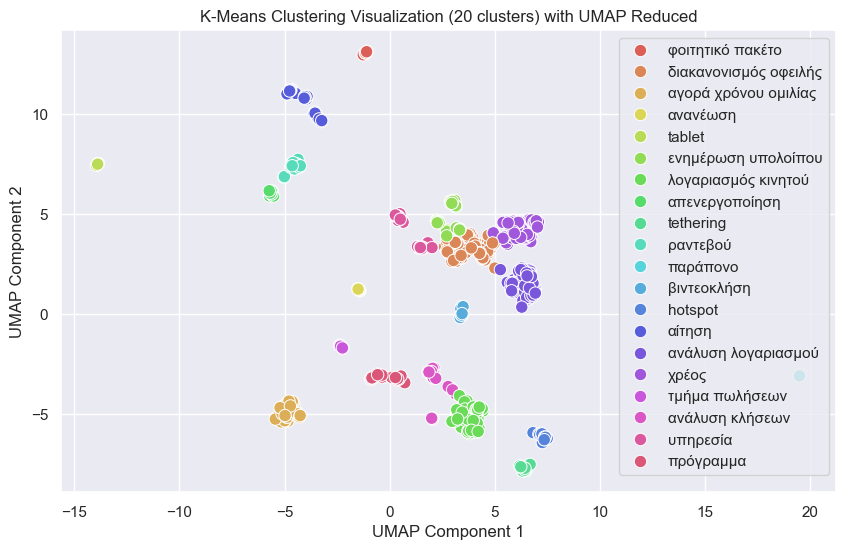

In [20]:
# new list of cluster names based on kmeans_labels
cluster_names = [cluster_labels.get(label, f"Cluster {label}") for label in kmeans_labels]

#Visualization of clusters with names instead of numbers
sns.set(style="darkgrid")
custom_palette = sns.color_palette("hls", n_colors=best_k)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=cluster_names, palette=custom_palette, legend='full', s=80)
plt.title(f"K-Means Clustering Visualization ({best_k} clusters) with UMAP Reduced")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()


In [25]:
# 'data' list into a DataFrame
data = pd.DataFrame(data, columns=["Utterance"])

# assuming kmeans_labels is an array of cluster numbers assigned by KMeans
#ensuring kmeans_labels is a numpy array and of type int
kmeans_labels = np.array(kmeans_labels, dtype=int)

#adding the numeric cluster labels from KMeans as a new column in the DataFrame
data['Cluster'] = kmeans_labels  # numeric cluster labels

# mapping the numeric cluster labels to their corresponding names using the cluster_labels dictionary
data['Cluster Name'] = data['Cluster'].map(cluster_labels)

#saving the updated DataFrame to a new csv
data.to_csv("files/Customer_Utterances_with_cluster_names.csv")

#printing the updated dataframe with cluster names
print(data.head())  # preview the first few rows of the updated dataframe


                                  Utterance  Cluster           Cluster Name
0           πρέπει έχω πάσο βάλω φοιτητικός       11       φοιτητικό πακέτο
1  θέλω κάνω διακανονισμός όλο ληξιπρόθεσμο       14  διακανονισμός οφειλής
2                        θέλω χρόνος μιλάως        0   αγορά χρόνου ομιλίας
3                       χρειάζομαι ανανέωση       16               ανανέωση
4              τo παραστατικός σταθερού μου       14  διακανονισμός οφειλής


In [ ]:
# intent prediction function
def get_intent(user_query):
    processed_query = preprocess_text(user_query)
    query_embedding = model.encode([processed_query], convert_to_numpy=True, normalize_embeddings=True)
    query_umap = umap_model.transform(query_embedding)
    cluster = kmeans.predict(query_umap)[0]
    
    #mappig cluster number to the cluster name
    cluster_name = cluster_labels.get(cluster, f"Cluster {cluster}")
    
    return f"Predicted Intent Cluster: {cluster_name}"

#basic ui, asking for user input
user_input = input("Please enter your query: ")

#getting predicted intent for given user case 
print(get_intent(user_input))

/opt/homebrew/Caskroom/miniconda/base/envs/venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Predicted Intent Cluster: αγορά χρόνου ομιλίας
